In [1]:
from utils.nnmodel import init_model_dropout

In [12]:
from utils.nnmodel import init_model_dropout
model_params={}
model_params['hidden units']=[32,32]
model_dropout=init_model_dropout(model_params)
model_dropout.build(input_shape=data.train.feature_matrix.shape)
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
model_dropout.load_weights(dropout_model_weight)


NameError: name 'data' is not defined

In [6]:
test_policy_scores_dropout = model_dropout(data.test.feature_matrix,training=True)[:, 0].numpy()

In [7]:
print(test_policy_scores_dropout[:4])

[-7.73303646 -8.94681177 -1.35511425 -8.11032018]


In [8]:
qid=20
for qid in range(100):
    q_feat = data.train.query_feat(qid)
    q_doc_weight= data.train.query_labels(qid)
    # print(q_doc_weight.shape)
    # print(q_feat.shape)
    if q_doc_weight.max()==4:
        print(qid)
        break

4


In [12]:
qid=8
q_feat = data.train.query_feat(qid)
q_doc_weight= data.train.query_labels(qid)
print(q_doc_weight)
# scores_dropout = model_dropout(data.test.feature_matrix,training=True)[:, 0].numpy()
scores_dropout = model_dropout(q_feat)[:, 0].numpy()
print(scores_dropout)

[1 0 2 2 2 2 1 2 1 2 2 2 1 1]
[-12.15348365 -13.23544685  -7.81623747 -13.12573593  -7.70505845
  -5.02370437 -13.31362957 -14.16474285  -8.64949926  -1.55455373
  -6.03480876  -7.19774608  -5.11649533  -4.82162626]


[-12.31513096 -12.93576163  -8.01803822 -13.24372818  -7.943201
  -5.1473652  -13.74455074 -13.86530913  -8.2434268   -1.59838312
  -6.11828864  -6.90757808  -4.99936181  -5.02794478] [2.92906746 3.68969517 1.91980705 3.16092842 1.90332088 1.40964572
 3.41513579 3.12971229 2.74833146 1.03755231 1.68693574 2.17180868
 1.449448   1.46404105]


In [14]:
score_mat=[]
for i in range(100):
    scores_dropout = model_dropout(q_feat,training=True)[:, 0].numpy()
    score_mat.append(scores_dropout)
score_mat=np.stack(score_mat)
mean,std=np.mean(score_mat,axis=0),np.std(score_mat,axis=0)
ind_sorted=np.argsort(-mean)
score_mat=score_mat[:,ind_sorted]
print(mean[ind_sorted],std[ind_sorted])
print(q_doc_weight[ind_sorted])
print(ind_sorted)

[ -1.51980029  -4.89106536  -5.1526773   -5.29136438  -6.30291559
  -7.01099137  -7.53528474  -8.10399671  -8.22222884 -12.07195938
 -13.03982705 -13.24142425 -13.36775758 -14.13651838] [0.88997673 1.46900632 1.5059301  1.52267288 1.49018747 1.78687375
 1.91324152 2.28096584 2.36658571 3.04836768 2.94667622 3.172614
 3.27920324 3.4318886 ]
[2 1 1 2 2 2 2 2 1 1 2 1 0 2]
[ 9 12 13  5 10 11  4  2  8  0  3  6  1  7]


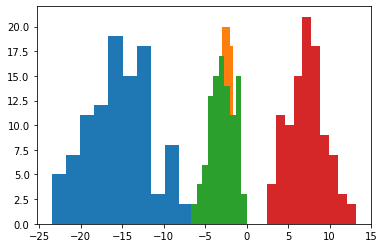

In [11]:
import matplotlib.pyplot as plt
# for column in df:
for column in score_mat[:,ind_sorted[:2]].T:
    plt.hist(column)
for column in score_mat[:,ind_sorted[-2:]].T:
    plt.hist(column)

In [31]:
## try to understand the 
sampled_ranking=np.arange(5)
sampled_rankings=np.tile(sampled_ranking,(2,1))
print(sampled_rankings.shape)

weight_per_rank=np.arange(20,10,-1)/30
weight_per_doc=np.arange(10,0,-1)/10
log_scores=np.arange(15,5,-1)/10*2
cutoff=5


(2, 5)


In [32]:
log_scores.shape

(10,)

In [70]:
np.log10(10**4)

4.0

In [1]:
def correlation(data, model,correlation_fn,n_sample=100):
    corr={"mean_std_corr":[],"label_std_corr":[],"label_mean_corr":[]}
    mean,std=MCDP_mean_std(data.feature_matrix,model,n_sample)
    for qid in progressbar(range(data.num_queries())):
        q_doc_weight= data.query_labels(qid)  
        n_doc=  q_doc_weight.shape[0]    
        if n_doc<3 or np.all(q_doc_weight == q_doc_weight[0]):
            # print(qid)
            continue
        mean_cur=data.query_values_from_vector(qid,mean)
        std_cur=data.query_values_from_vector(qid,std)
        corr["mean_std_corr"].append(correlation_fn(mean_cur,std_cur)[0])
        label_std_corr=correlation_fn(q_doc_weight,std_cur)[0]
        # print(qid,label_std_corr,q_doc_weight.shape,q_doc_weight.sum())
        
        corr["label_std_corr"].append(label_std_corr)
        corr["label_mean_corr"].append(correlation_fn(q_doc_weight,mean_cur)[0])
    for i in corr.keys():
        corr[i]=np.mean(corr[i])
    print(corr)
    return corr

def MCDP_mean_std(q_feat,model,n_samples=100):
    '''
        q_feat: input feautures: [seq_len,feature_len]
        model: NN model with dropout
    '''

    score_mat=nn.get_score_matrix_by_dropout(q_feat,model,n_samples=n_samples)
    mean,std=np.mean(score_mat,axis=0),np.std(score_mat,axis=0)
    return mean,std


In [1]:
import sys
sys.path.append("../")
import argparse
import json
import numpy as np
import tensorflow as tf
import time

import utils.click_generation as clkgn
import utils.clicks as clk
import utils.dataset as dataset
import utils.estimators as est
import utils.evaluation as evl
import utils.nnmodel as nn

import utils.optimization as opt
import utils.misc as misc
from progressbar import progressbar
from utils.nnmodel import init_model_dropout
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
tf.enable_eager_execution()

In [7]:
setting={"output_path":"log.txt","fold_id":1,"click_model":"default","dataset":"MSLR-WEB30k_beh_rm","cutoff":5,\
    "dataset_info_path":"local_dataset_info.txt","cutoff":5,"n_updates":5,"pretrained_model":"local_output/pretrained_model.h5"}
from argparse import Namespace
args = Namespace(**setting)
click_model_name = args.click_model
cutoff = args.cutoff
n_updates = args.n_updates
data = dataset.get_dataset_from_json_info(
                  args.dataset,
                  args.dataset_info_path,
                  shared_resource = False,
                )
fold_id = (args.fold_id-1)%data.num_folds()
data = data.get_data_folds()[fold_id]
start = time.time()
data.read_data()

In [5]:
model_params={}
model_params['hidden units']=[32,32]
model_dropout=init_model_dropout(model_params)
model_dropout.build(input_shape=data.train.feature_matrix.shape)
dropout_model_weight="pretrained/MSLR-WEB30k_beh_rm1%/supervised/trial0/model.h5"
model_dropout.load_weights(dropout_model_weight)

In [10]:
for i in progressbar(range(100)):
    for q in progressbar(range(data.train.num_queries())):
        feat=data.train.query_values_from_vector(q,data.train.feature_matrix)
        model_dropout(feat)

100% (18918 of 18918) |##################| Elapsed Time: 0:00:38 Time:  0:00:38
 38% (7285 of 18918) |#######            | Elapsed Time: 0:00:14 ETA:   0:00:23

KeyboardInterrupt: 

In [11]:
from utils.misc import *

In [15]:
n1,n2=efficient_spacing(50,10,0,6,True)

In [24]:
n_d=50//10

In [28]:
print(n1.shape)

(50,)


In [7]:
import numpy as np
test_doc_freq=np.ones(10)
cur_train_rankings=np.random.randint(0,10,(5,10000))
np.add.at(test_doc_freq,cur_train_rankings,1) 
print(test_doc_freq)

[5059. 4995. 4982. 5009. 5050. 5049. 5062. 5005. 4968. 4831.]


In [33]:
n1[n_d//2::n_d].shape

(10,)

In [9]:
info_path="example_datasets_info.txt"
with open(info_path) as f:
    all_info = json.load(f)

In [1]:
##### Below is 
#  get the correlation .
### some function

###
import sys
sys.path.append("../")
import argparse
import json
import numpy as np
import tensorflow as tf
import time

import utils.click_generation as clkgn
import utils.clicks as clk
import utils.dataset as dataset
import utils.estimators as est
import utils.evaluation as evl
import utils.nnmodel as nn

import utils.optimization as opt
import utils.misc as misc
from progressbar import progressbar
from utils.nnmodel import init_model_dropout
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
tf.enable_eager_execution()

setting={"output_path":"log.txt","fold_id":1,"click_model":"default","dataset":"Webscope_C14_Set1","cutoff":5,\
    "dataset_info_path":"local_dataset_info.txt","cutoff":5,"n_updates":5,"pretrained_model":"local_output/pretrained_model.h5"}
from argparse import Namespace
args = Namespace(**setting)
click_model_name = args.click_model
cutoff = args.cutoff
n_updates = args.n_updates
data = dataset.get_dataset_from_json_info(
                  args.dataset,
                  args.dataset_info_path,
                  shared_resource = False,
                )
fold_id = (args.fold_id-1)%data.num_folds()
data = data.get_data_folds()[fold_id]
start = time.time()
data.read_data()


model_params={}
model_params['hidden units']=[32,32]
model_dropout=init_model_dropout(model_params)
model_dropout.build(input_shape=data.train.feature_matrix.shape)
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
model_dropout.load_weights(dropout_model_weight)
from scipy.stats import pearsonr
from scipy.stats import spearmanr

max_ranking_size = np.min((cutoff, data.max_query_size()))
click_model = clk.get_click_model(args.click_model)
alpha, beta = click_model(np.arange(max_ranking_size))

true_train_doc_weights = data.train.label_vector*0.25
true_vali_doc_weights = data.validation.label_vector*0.25
true_test_doc_weights = data.test.label_vector*0.25
# corr_dict_train=correlation(data.train,model_dropout,pearsonr,n_sample=10)
# from pandas import DataFrame
# df=DataFrame.from_dict(corr_dict_train)
# df.mean()

# corr_dict_train=correlation(data.train,model_dropout,spearmanr,n_sample=10)
# from pandas import DataFrame
# df=DataFrame.from_dict(corr_dict_train)
# df.mean()


In [54]:
data.train.feature_matrix.shape

(473092, 501)

In [59]:
y = np.ma.array([1, 2, 3], mask = [0, 1, 0])
print(y)
print(y.mean())

[1 -- 3]
2.0


In [70]:
y.argsort()

array([0, 2, 1])

In [55]:
data_split=data.train

In [66]:
n_docs=data_split.num_docs()
mask=np.zeros(n_docs).astype(np.int)

In [62]:
random=np.random.randint(1,23)
print(random)

20


In [74]:
set_mask(data_split,mask,low=5,high=10)

In [99]:
def get_mask(data_split,low=5,high=10):
    n_docs=data_split.num_docs()
    mask=np.zeros(n_docs).astype(np.int)
    num_queries=data_split.num_queries()
    for query in range(num_queries):
        mask_query=data_split.query_values_from_vector(query,mask)
        n_mask_query=len(mask_query)
        if n_mask_query<=low:
            mask_query[:]=1
        else:
            high_mask=min(n_mask_query,high)
            random=np.random.randint(low,high_mask)
            true_mask_ind=np.random.choice(n_mask_query, random, replace=False)
            mask_query[true_mask_ind]=1
    return mask

def update_mask(mask_query,unshown_list,prob=0.2):
    if np.random.random()<prob and unshown_list:
        incoming_id=unshown_list.pop()
        mask_query[incoming_id]=1
        print(incoming_id)
    

    

In [103]:
train_mask=set_mask(data_split,low=5,high=10)

In [104]:
query=4
mask_query=data_split.query_values_from_vector(query,train_mask)
n_mask_query=len(mask_query)
unshown=np.arange(n_mask_query)[mask_query==0]
np.random.shuffle(unshown)
unshown=unshown.tolist()
update_mask(mask_query,unshown,0.8)

9


In [126]:
policy_scores=np.random.uniform(-1,1,size=(len(mask_query),10))

In [116]:
d*mask_query

array([ 0.        , -0.        ,  0.55578094, -0.        ,  0.38156998,
        0.        , -0.        ,  0.22298477,  0.        ,  0.04775692,
        0.65053474,  0.        , -0.        , -0.09587865,  0.86258459,
        0.71939584,  0.        , -0.        , -0.9756671 ])

In [117]:
np.inf*(1-mask_query)

/home/ec2-user/miniconda3/envs/pt_ranking/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


array([inf, inf, nan, inf, nan, inf, inf, nan, inf, nan, nan, inf, inf,
       nan, nan, nan, inf, inf, nan])

In [129]:
policy_scores_masked=policy_scores*mask_query[:,None]
policy_scores_masked[mask_query==0]=-np.inf

In [3]:
import numpy as np
d=np.ones(5)
dd=[d,d]
ddd=np.array(dd)
print(ddd)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [130]:
policy_scores_masked[:,:2]

array([[       -inf,        -inf],
       [       -inf,        -inf],
       [ 0.19021566,  0.23075096],
       [       -inf,        -inf],
       [ 0.98990189, -0.24509483],
       [       -inf,        -inf],
       [       -inf,        -inf],
       [-0.26820537,  0.04747729],
       [       -inf,        -inf],
       [-0.14898797,  0.05384151],
       [-0.51180175, -0.18851466],
       [       -inf,        -inf],
       [       -inf,        -inf],
       [ 0.57300216,  0.07417666],
       [-0.49040834, -0.73848896],
       [ 0.43076235,  0.50315465],
       [       -inf,        -inf],
       [       -inf,        -inf],
       [ 0.43787504,  0.44929544]])

In [124]:
policy_scores_masked

array([       -inf,        -inf, -0.17609374,        -inf,  0.4749152 ,
              -inf,        -inf,  0.70322258,        -inf, -0.35614605,
       -0.16714521,        -inf,        -inf, -0.82924663, -0.1017613 ,
       -0.38390394,        -inf,        -inf,  0.15728631])

In [112]:
d

array([ 0.59895163, -0.98547492,  0.55578094, -0.81645738,  0.38156998,
        0.04105083, -0.34951772,  0.22298477,  0.32913293,  0.04775692,
        0.65053474,  0.92735523, -0.44991194, -0.09587865,  0.86258459,
        0.71939584,  0.20912736, -0.21319322, -0.9756671 ])

In [111]:
mask_query.shape

(19,)

In [95]:
mask_query

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [90]:
mask_query

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [76]:
unshown

array([ 1,  2,  8, 11, 13, 14, 16])

In [71]:
np.random.random()

0.8935315175550436

In [97]:
d=[] 
if d:
    print("fdas")

In [98]:
import utils.plackettluce as pl
clicks=np.random.randint(0,2,size=(10,5))
print(clicks)
pl.cDCG(clicks)

[[1 1 1 0 0]
 [1 0 0 0 1]
 [1 1 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 1]
 [1 0 0 0 0]
 [0 1 0 0 1]
 [1 1 1 1 0]
 [0 1 0 1 1]
 [0 0 1 0 1]]


array([2.13092975, 1.38685281, 2.06160631, 0.38685281, 0.88685281,
       1.        , 1.01778256, 2.56160631, 1.44845912, 0.88685281])

mean length for queries 23.722208293636864


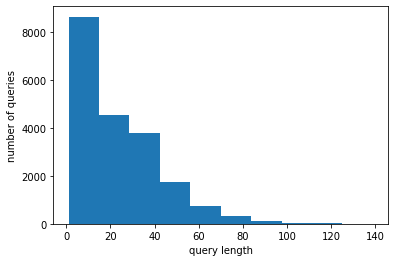

Text(0, 0.5, 'number of queries')

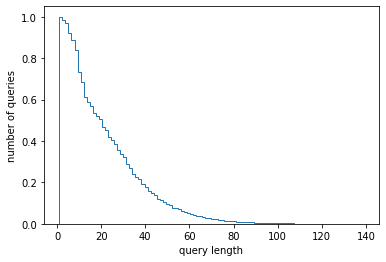

In [18]:
print("mean length for queries",data.train.query_sizes().mean())
import matplotlib.pyplot as plt
plt.hist(data.train.query_sizes())
plt.xlabel("query length")
plt.ylabel("number of queries")
plt.show()
plt.hist(data.train.query_sizes(),bins=100,density=True, histtype='step', cumulative=-1,)
plt.xlabel("query length")
plt.ylabel("number of queries")

In [3]:
n_samples=10**8
data_split=data.train
doc_weights=true_train_doc_weights
train_policy_scores= model_dropout(data.train.feature_matrix)[:, 0].numpy()
train_ranking_param={"policy_scores":train_policy_scores,
                  "intervene_strategy":"gumbel",
                  "select_fn":data.train.query_values_from_vector}
vali_policy_scores= model_dropout(data.validation.feature_matrix)[:, 0].numpy()
vali_ranking_param={"policy_scores":vali_policy_scores,
                  "intervene_strategy":"gumbel",
                  "select_fn":data.validation.query_values_from_vector}
# a,b,c=clkgn.simulate_queries_intervene(data_split,10**7,doc_weights,alpha, beta,train_ranking_param)
# print(a.shape,b.shape,len(c))

In [6]:
qid=4
(new_clicks,new_ranking) = clkgn.single_query_generation_intervene(
                        qid,
                        data.train,
                        100,
                        doc_weights,
                        alpha,
                        beta,
                        # model=model,
                        ranking_param=train_ranking_param)

In [34]:
import utils.plackettluce as pl
weight_per_rank=np.log2(np.arange(2,7))[:,None]
print(weight_per_rank.shape)
addition_per_rank=np.zeros_like(weight_per_rank)
q_doc_weights=data.train.query_values_from_vector(qid,true_train_doc_weights)
results = pl.NDCG_based_on_samples(new_ranking, 
                                q_doc_weights
                                )
print(results)

(5, 1)
[0.85377524 0.95277081 0.84923804 0.93203804 0.91848252 0.85310456
 0.82850527 0.88560783 0.92565977 0.8091861  0.81489369 0.82844921
 0.88560783 0.84016365 0.61009679 0.91848252 0.86671614 0.8266642
 0.86671614 0.8266642  0.83562646 0.84923804 0.78386007 0.74159556
 0.8802156  0.5496835  0.83562646 0.84923804 0.92565977 0.81801729
 0.90487094 0.82127196 0.89382718 0.95277081 0.82844921 0.65014873
 0.87843058 0.85310456 0.80200885 0.84206079 0.91848252 0.86671614
 0.76625091 0.70810625 0.93203804 0.60144988 0.8802156  0.62143974
 0.82850527 0.60782815 0.84206079 0.86671614 0.78845333 0.89051644
 0.90487094 0.80200885 0.74159556 0.81489369 0.87843058 0.82850527
 0.81863191 0.91848252 0.82844921 0.84206079 0.91848252 0.91848252
 0.93203804 0.90818167 0.84206079 0.76232833 0.76625091 0.86671614
 0.84206079 0.91848252 0.78845333 0.77030455 0.91848252 0.82850527
 0.86671614 0.91848252 0.81489369 0.76625091 0.8802156  0.82850527
 0.65014873 0.78845333 0.92565977 0.91848252 0.85310456 

In [39]:
import utils.plackettluce as pl
q_doc_weights=data.train.query_values_from_vector(qid,true_train_doc_weights)
results = pl.NDCG_based_on_samples(new_ranking, 
                                    q_doc_weights,
                                    )

In [40]:
results

array([0.85377524, 0.95277081, 0.84923804, 0.93203804, 0.91848252,
       0.85310456, 0.82850527, 0.88560783, 0.92565977, 0.8091861 ,
       0.81489369, 0.82844921, 0.88560783, 0.84016365, 0.61009679,
       0.91848252, 0.86671614, 0.8266642 , 0.86671614, 0.8266642 ,
       0.83562646, 0.84923804, 0.78386007, 0.74159556, 0.8802156 ,
       0.5496835 , 0.83562646, 0.84923804, 0.92565977, 0.81801729,
       0.90487094, 0.82127196, 0.89382718, 0.95277081, 0.82844921,
       0.65014873, 0.87843058, 0.85310456, 0.80200885, 0.84206079,
       0.91848252, 0.86671614, 0.76625091, 0.70810625, 0.93203804,
       0.60144988, 0.8802156 , 0.62143974, 0.82850527, 0.60782815,
       0.84206079, 0.86671614, 0.78845333, 0.89051644, 0.90487094,
       0.80200885, 0.74159556, 0.81489369, 0.87843058, 0.82850527,
       0.81863191, 0.91848252, 0.82844921, 0.84206079, 0.91848252,
       0.91848252, 0.93203804, 0.90818167, 0.84206079, 0.76232833,
       0.76625091, 0.86671614, 0.84206079, 0.91848252, 0.78845

In [33]:
  (cur_train_rankings,cur_train_clicks,\
  cur_train_qids,cur_vali_rankings,\
  cur_vali_clicks,cur_vali_qids)=clkgn.simulate_on_dataset_intervene(
                                                data.train,
                                                data.validation,
                                                10**7,
                                                true_train_doc_weights,
                                                true_vali_doc_weights,
                                                alpha,
                                                beta,
                                              train_ranking_param=train_ranking_param,
                                              vali_ranking_param=vali_ranking_param)

100% (18400 of 18400) |##################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (2753 of 2753) |####################| Elapsed Time: 0:00:23 Time:  0:00:23


In [22]:
selected_query=np.where(data.train.query_sizes()>cutoff)[0]
print(selected_query.shape)

(18400,)


In [23]:
selected_query 

array([    1,     3,     4, ..., 19940, 19941, 19942])

In [4]:
n_samples=100
data_split=data.train
train_policy_scores= model_dropout(data.train.feature_matrix)[:, 0].numpy()
train_ranking_param={"policy_scores":train_policy_scores,
                  "intervene_strategy":"gumbel",
                  "select_fn":data.train.query_values_from_vector}
expected_alpha, expected_beta=est.expected_alpha_beta_intervene(data_split,
                     n_samples,
                     alpha,
                     beta,
                     **train_ranking_param)


100% (19943 of 19943) |##################| Elapsed Time: 0:00:12 Time:  0:00:12


In [8]:
### I will plot the mean|std, how it evolves with time.
import re
model_params={}
model_params['hidden units']=[32,32]
model_dropout=init_model_dropout(model_params)
model_dropout.build(input_shape=data.train.feature_matrix.shape)
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
model_dropout.load_weights(dropout_model_weight)

base="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings_sigmoid/dropout/n_updates_10/trial_1/"
import glob
models=glob.glob(base+"*.h5")
steps=[]
results=[]
for model_name in models:
    step=int(re.findall(r'\d+',model_name)[0])
    steps.append(step)
    model_dropout.load_weights(model_name)
    corr_dict_train=correlation(data.train,model_dropout,spearmanr,n_sample=20)
    results.append(corr_dict_train)


100% (20 of 20) |########################| Elapsed Time: 0:00:57 Time:  0:00:57
100% (19943 of 19943) |##################| Elapsed Time: 0:00:44 Time:  0:00:44
N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--{'mean_std_corr': -0.02495668116476544, 'label_std_corr': 0.0020971939995610847, 'label_mean_corr': 0.20345858071426662}
100% (20 of 20) |########################| Elapsed Time: 0:00:57 Time:  0:00:57
100% (19943 of 19943) |##################| Elapsed Time: 0:00:42 Time:  0:00:42
N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--{'mean_std_corr': 0.04630446380060519, 'label_std_corr': 0.03432828006967585, 'label_mean_corr': 0.23420115577665038}
100% (20 of 20) |########################| Elapsed Time: 0:00:57 Time:  0:00:57
100% (19943 of 19943) |##################| Elapsed Time: 0:00:42 Time:  0:00:42
N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--{'mean_std_corr': 0.04132352131267113, 'labe

In [20]:

for i in path:
    model_name=i.split("/")[-1]
    ex=int(re.findall(r'\d+',model_name)[0])
    print(ex)
    corr_dict_train=correlation(data.train,model_dropout,pearsonr,n_sample=50)

240
577
1389
3340
5179
12451
29935


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

import utils.dataset as dataset
data_setting={"dataset_info_path":"local_dataset_info.txt",
         "dataset":"Webscope_C14_Set1",
         "fold_id":1 }
data=dataset.get_data(**data_setting)

In [1]:

import sys
sys.path.append("../")
import argparse
import json
import numpy as np
import tensorflow as tf
import time
import utils.dataset as dataset
import utils.nnmodel as nn
import utils.misc as misc
import utils.evaluation as evl
from progressbar import progressbar
from scipy.stats import pearsonr
from scipy.stats import spearmanr
%config Completer.use_jedi = False
tf.enable_eager_execution()

import utils.dataset as dataset
data_setting={"dataset_info_path":"local_dataset_info.txt",
         "dataset":"Webscope_C14_Set1",
         "fold_id":1 }
data=dataset.get_data(**data_setting)

model_params={}
model_params['hidden units']=[32,32]
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/supervised/trial0/model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/direct/n_updates_10/trial_0/24040_steps_model.h5"
get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":False}
model_dropout=nn.get_dropout_model(**get_model_params)

true_train_doc_weights = data.train.label_vector*0.25
true_vali_doc_weights = data.validation.label_vector*0.25
true_test_doc_weights = data.test.label_vector*0.25



{'Webscope_C14_Set1': {'num_folds': 1, 'fold_paths': ['/raid/datasets/shared/Yahoo/'], 'num_relevance_labels': 5, 'num_nonzero_feat': 519, 'num_unique_feat': 501, 'query_normalized': True, 'feature_filter_dim': []}, 'MSLR-WEB30k': {'num_folds': 5, 'fold_paths': ['/raid/datasets/shared/MSLR-WEB30K/Fold1/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold2/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold3/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold4/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold5/'], 'num_relevance_labels': 5, 'num_nonzero_feat': 136, 'num_unique_feat': 131, 'query_normalized': True, 'feature_filter_dim': []}, 'MSLR-WEB30k_beh_rm': {'num_folds': 5, 'fold_paths': ['/raid/datasets/shared/MSLR-WEB30K/remove_behavior/Fold1/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold2/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold3/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold4/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold5/'], 

OSError: Unable to open file (unable to open file: name = '/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/direct/n_updates_10/trial_0/24040_steps_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
train_clicks.shape

(1, 473092)

In [18]:
input_feature.shape

(473092, 501)

In [4]:
input_feature=data.train.feature_matrix

In [38]:
train_clicks = np.zeros(data.train.num_docs())

In [39]:
train_clicks.shape

(473092,)

In [ ]:
train_clicks

In [41]:
input_feature.shape

(473092, 504)

In [42]:
input_feature=np.concatenate([input_feature,train_clicks[:,None]],axis=1)

In [34]:
input_feature[1]

array([9.36931834e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       5.88828309e-01, 3.95984910e-01, 0.00000000e+00, 9.86592446e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.15132214e-01, 0.00000000e+00, 5.12771100e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.95472453e-01, 2.37588018e-02,
       5.42068352e-01, 0.00000000e+00, 1.64218304e-03, 0.00000000e+00,
       7.66603197e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.15641711e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 5.90979117e-01,
       0.00000000e+00, 7.66739120e-01, 2.16579825e-01, 3.86115143e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.70075252e-01, 0.00000000e+00,
       6.62450235e-01, 0.00000000e+00, 5.46324270e-01, 0.00000000e+00,
      

In [50]:
n_dropout=10
q_batch_size=2**15



In [54]:
param={"model":model_dropout,"model_params":model_params,"input_feature":input_feature,
        "data_split":data.train,"n_dropout":n_dropout,"q_batch_size":q_batch_size}

scores_dropout=nn.scores_dropout_direct_model(**param)

In [61]:
nn.get_corre_stat(data.train,scores_dropout)[1]

0.9537979306600284

In [63]:
evl.correlation(data.train,scores_dropout)

{'mean_std_corr': 0.2552678132592147,
 'label_std_corr': 0.05539750718326399,
 'label_mean_corr': 0.24733225858332467}

In [57]:
scores_dropout[:2]

array([[0.14160391, 0.37622668, 0.60267146, 0.67546182, 0.31385957,
        0.41641829, 0.47148956, 0.23299998, 0.46081278, 0.3615406 ],
       [0.16117523, 0.25823764, 0.3023841 , 0.30760827, 0.22217662,
        0.24628529, 0.27337379, 0.21511162, 0.27087328, 0.197125  ]])

In [112]:
def get_data_statics(data_name_list=[]):
    stas_list=[]
    for data_name in data_name_list:
        data_setting={"dataset_info_path":"local_dataset_info.txt",
                 "dataset":data_name,
                 "fold_id":1 }
        data=dataset.get_data(**data_setting)
        stats=dataset.get_data_stat(data)
        stas_list.append(stats)
    return stas_list

In [3]:
data_name_list=["MQ2007","MQ2008","MSLR-WEB10k_beh_rm","MSLR-WEB30k_beh_rm","istella-s"]

In [117]:
stas_list

[autoreload of utils.dataset failed: Traceback (most recent call last):
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/taoyang/miniconda3/envs/ultra_p36/lib/python3.6

[[1643, 41.0, 41],
 [728, 20.0, 40],
 [9835, 122.0, 128],
 [30995, 121.0, 128],
 [32966, 103.0, 193]]

In [2]:
stas_list=[[1643, 41.0, 41],
 [728, 20.0, 40],
 [9835, 122.0, 128],
 [30995, 121.0, 128],
 [32966, 103.0, 193]]

In [7]:
import pandas as pd
df = pd.DataFrame(stas_list,index=data_name_list,columns=["# Queries","# Average documents","# Unique feature"])

In [110]:
# data_setting={"dataset_info_path":"local_dataset_info.txt",
#          "dataset":"Webscope_C14_Set1",
#          "fold_id":1 }
# data_yahoo=dataset.get_data(**data_setting)




get_data_stat(data_yahoo)

filterd and removed  1543 in 19943 ratio is 0.07737050594193451
filterd and removed  240 in 2993 ratio is 0.0801871032408954
filterd and removed  378 in 6734 ratio is 0.05613305613305608


[27509, 25.0, 501]

In [104]:
data=data_yahoo
data.train.query_sizes()[data.train.get_filtered_queries()]+\
                data.test.query_sizes()[data.test.get_filtered_queries()]
#                 data.validation.query_sizes()[data.validation.get_filtered_queries()]

ValueError: operands could not be broadcast together with shapes (18400,) (6356,) 

In [100]:
data_yahoo.train.query_sizes()[data_yahoo.train.get_filtered_queries()]

array([13,  8, 19, ..., 37, 48, 37])

In [99]:
data_yahoo.train.get_filtered_queries().shape

(18400,)

In [8]:
cur_train_qids=np.random.randint(0,100,(100))
def get_docids_from_qids(qids,data_split):
training_qid=[]
for qid in cur_train_qids:
    start,end=data_split.query_range(qid)
    training_qid+=list(range(start,end))


In [13]:
data_setting={"dataset_info_path":"local_dataset_info.txt",
         "dataset":"istella-s",
         "fold_id":1 }
istella_data=dataset.get_data(**data_setting)
get_data_stat(istella_data)

103.30050635214214
32981


In [14]:
data_setting={"dataset_info_path":"local_dataset_info.txt",
         "dataset":"MSLR-WEB30k",
         "fold_id":1 }
mslr_30k_data=dataset.get_data(**data_setting)

get_data_stat(mslr_30k_data)


120.19059319059319
31339


In [57]:
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/direct/n_updates_10/trial_0/24040_steps_model.h5"
get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":False}
model_dropout=nn.get_dropout_model(**get_model_params)
feat=data.train.feature_matrix
scores=nn.get_score_matrix_by_dropout(feat,model_dropout,10)

100% (10 of 10) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


In [60]:
scores.mean(axis=-1).shape

(473092,)

In [10]:
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/direct/n_updates_10/trial_0/24040_steps_model.h5"
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise_good_initial_model/Webscope_C14_Set1/direct/n_updates_10/trial_0/final_model.h5"

dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise_good_initial_model/Webscope_C14_Set1/direct/n_updates_10/trial_0/372_steps_model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/pretrained/Webscope_C14_Set1/supervised/trial1/model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/pretrained/Webscope_C14_Set1/pretrained_fully/trial0/model.h5"
get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":True}
model_dropout=nn.get_dropout_model(**get_model_params)
# feat=data.train.feature_matrix
# scores_gpu=nn.get_score_matrix_by_dropout(feat,model_dropout,10,use_GPU=True)




NameError: name 'model_params' is not defined

In [31]:
scores_nogpu=nn.get_score_matrix_by_dropout(feat,model_dropout,10,use_GPU=False)
cor_nogpu=nn.get_corre_stat(data.train,scores_nogpu)
print(cor_nogpu)

[0.99883706 0.99883706]


In [27]:
cor_nogpu=nn.get_corre_stat(data.train,scores_nogpu)
print(cor_nogpu)

[0.99907283 0.99907283]


In [ ]:
cor_nogpu=nn.get_corre_stat(data.train,scores_nogpu)
print(cor_nogpu)

[0.99813373 0.99813373]


In [20]:
cor_gpu=nn.get_corre_stat(data.train,scores_gpu)
print(cor_gpu)

[0.33138792 0.07961169]


In [16]:
cor_nogpu=nn.get_corre_stat(data.train,scores_nogpu)
print(cor_nogpu)
cor_gpu=nn.get_corre_stat(data.train,scores_gpu)
print(cor_gpu)

[0.99845532 0.99845532]
[0.99182109 0.99059888]


In [ ]:
print("fdas")

In [18]:
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/direct/n_updates_10/trial_0/57796_steps_model.h5"

get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":False}
model_dropout=nn.get_dropout_model(**get_model_params)
cur_weight=model_dropout.get_weights()


In [1]:
%load_ext autoreload
%autoreload 2

In [10]:

import utils.plackettluce as pl
score_no_shuffle=np.zeros_like(scores_dropout)
score_no_shuffle[:]=scores_dropout
score_no_shuffle_T=score_no_shuffle.T
n_samples=100
print("*"*50)
print("Dropout no shuffle")
metrics =  pl.datasplit_metrics(
                  data_split,
                  score_no_shuffle_T,
                  stacked_alphas,
                  stacked_betas,
                  doc_weights,
                  query_norm_factors=norm_factors,
                  n_samples=n_samples,intervene_strategy="rankings_n_samples"
                )
print(metrics)
print("*"*50)
print("\n\n")
print("*"*50)
print("Dropout shuffle")
score_shuffle=np.zeros_like(scores_dropout)
score_shuffle[:]=scores_dropout
for i in score_shuffle.T:
    np.random.shuffle(i)
score_shuffle_T=score_shuffle.T
n_samples=100
print(score_shuffle_T[0,:4])
metrics =  pl.datasplit_metrics(
                  data_split,
                  score_shuffle_T,
                  stacked_alphas,
                  stacked_betas,
                  doc_weights,
                  query_norm_factors=norm_factors,
                  n_samples=n_samples,intervene_strategy="rankings_n_samples"
                )
print(metrics)

print("*"*50)
print("\n\n")
print("*"*50)
print("mean score of Dropouts")
score_dropout_mean=np.mean(scores_dropout,axis=0)
score_dropout_mean=score_dropout_mean[:,None]
n_samples=1
print(score_shuffle_T[0,:4])
metrics =  pl.datasplit_metrics(
                  data_split,
                  score_dropout_mean,
                  stacked_alphas,
                  stacked_betas,
                  doc_weights,
                  query_norm_factors=norm_factors,
                  n_samples=n_samples,intervene_strategy="rankings_n_samples"
                )
print(metrics)
print("*"*50)
print("\n\n")
print("*"*50)
print("No Dropouts")
n_samples=100
scores_ensemble=model_dropout(data.test.feature_matrix).numpy()
metrics =  pl.datasplit_metrics(
                  data_split,
                  scores_ensemble,
                  stacked_alphas,
                  stacked_betas,
                  doc_weights,
                  query_norm_factors=norm_factors,
                  n_samples=n_samples,intervene_strategy="rankings_n_samples"
                )
print(metrics)

**************************************************
Dropout no shuffle


NameError: name 'data_split' is not defined

In [56]:
import utils.dataset as dataset
data_setting={"dataset_info_path":"local_dataset_info.txt",
        #  "dataset":"istella-s",
         "dataset":"NP2003",
         "fold_id":1 }
data=dataset.get_data(**data_setting)
true_train_doc_weights = data.train.label_vector
true_vali_doc_weights = data.validation.label_vector
true_test_doc_weights = data.test.label_vector

data.test.filtered_query_sizes(30)
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/istella-s/supervised/trial0/model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/supervised/trial0/model.h5"
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/istella-s/direct/n_updates_10/trial_0/output_final_model.h5"
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/istella-s/pretrained/trial0/model.h5"
# model_params = {'hidden units': [32, 32],}
# get_model_params={"model_params":model_params,
#                 "input_shape":data.train.feature_matrix.shape,
#                 "weight_path":dropout_model_weight,
#                 "dropout_fixed":False}
# model=nn.get_dropout_model(**get_model_params)


# model = nn.init_model_dropout(model_params)
# model.build(input_shape=data.train.feature_matrix.shape)

# model.load_weights(dropout_model_weight)

# cutoff=5
# cur_test_ndcg= evl.test_ndcg(
#                                 model,
#                                 data.test,
#                                 true_test_doc_weights,
#                                 cutoff
#                               )
# print(cur_test_ndcg)

{'Webscope_C14_Set1': {'num_folds': 1, 'fold_paths': ['/raid/datasets/shared/Yahoo/'], 'num_relevance_labels': 5, 'num_nonzero_feat': 519, 'num_unique_feat': 501, 'query_normalized': True, 'feature_filter_dim': []}, 'MSLR-WEB30k': {'num_folds': 5, 'fold_paths': ['/raid/datasets/shared/MSLR-WEB30K/Fold1/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold2/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold3/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold4/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold5/'], 'num_relevance_labels': 5, 'num_nonzero_feat': 136, 'num_unique_feat': 131, 'query_normalized': True, 'feature_filter_dim': []}, 'MSLR-WEB30k_beh_rm': {'num_folds': 5, 'fold_paths': ['/raid/datasets/shared/MSLR-WEB30K_rm_clicks/full/Fold1/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold2/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold3/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold4/', '/home/ec2-user/documents/datasets/MSLR-WEB30K/Fold5/'], '

In [57]:
true_train_doc_weights.mean()

0.0010130674315894914

In [58]:
len(true_train_doc_weights)

87852

In [53]:
(true_train_doc_weights==0).sum()

1170017

In [55]:
1170017/2270258

0.51536741639056

In [51]:
data.train.num_queries()

89

In [19]:
tf.set_random_seed(1)
model_params = {'hidden units': [32, 32],}
model = nn.init_model_dropout(model_params)
model.build(input_shape=data.train.feature_matrix.shape)

In [22]:
model.set_weights(model.get_weights())

In [20]:
model.weights

[<tf.Variable 'dense_21/kernel:0' shape=(501, 32) dtype=float64, numpy=
 array([[-0.03797344, -0.09595746, -0.03490393, ...,  0.03982586,
         -0.06404979, -0.02692457],
        [-0.08131753, -0.04390374, -0.00949303, ...,  0.01966166,
          0.06861302,  0.00465875],
        [-0.10511024, -0.09768358,  0.07247853, ..., -0.05531353,
          0.01284614,  0.08302015],
        ...,
        [-0.03180451, -0.07719004, -0.08731159, ...,  0.08231643,
          0.06764245,  0.04028468],
        [ 0.0228986 , -0.02248379,  0.00027828, ...,  0.03409316,
          0.09233527,  0.07186204],
        [ 0.05632144, -0.05432172, -0.04530755, ...,  0.05011292,
         -0.04200404, -0.02599188]])>,
 <tf.Variable 'dense_21/bias:0' shape=(32,) dtype=float64, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>,
 <tf.Variable 'dense_22/kernel:0' shape=(32, 32) dtype=float64, numpy=
 array([[-0.2566

In [ ]:
model_params = {'hidden units': [32, 32],}
model = nn.init_model_dropout(model_params)
logging_model = nn.init_model_dropout(model_params)

In [2]:
# dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/istella-s/supervised/trial0/model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/istella-s/direct/n_updates_10/trial_4/output_final_model.h5"
model_params={}
model_params['hidden units']=[32,32]
get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":True}
model_dropout=nn.get_dropout_model(**get_model_params)
scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,10)


NameError: name 'data' is not defined

In [123]:
qid=1012
data_split=data.train
cutoff=10
risk_preference_param_n=np.arange(-1000,1000,100)/10
qid_feature=data.test.query_values_from_vector(qid,data.test.feature_matrix)
# scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,10)
# score_qid=data_split.query_values_from_vector(qid,scores_dropout) 
score_qid=nn.get_score_matrix_by_dropout(qid_feature,model_dropout,100)

ranks_cur=nn.get_rank_profolio_multiple(score_qid,cutoff,risk_preference_param_n)[0]



100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


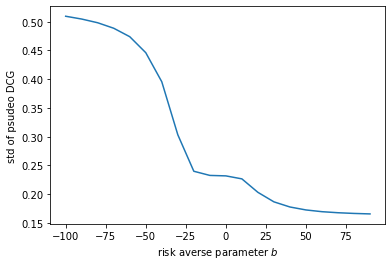

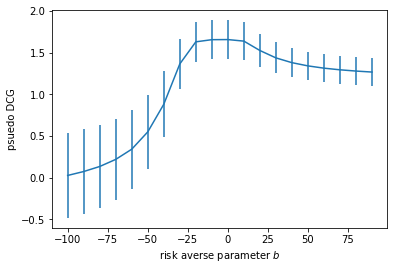

In [203]:
# scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,100)
# scores_dropout_test=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,100)
# risk_preference_param_n=np.arange(-100,100,10)
# mean,std=dcg_multi_query_portfolio(scores_dropout,scores_dropout_test,data.test,risk_preference_param_n)
plt.plot(risk_preference_param_n,std)
plt.xlabel("risk averse parameter $b$")
plt.ylabel("std of psudeo DCG")
plt.show()
plt.show()
plt.errorbar(risk_preference_param_n,mean,std)
plt.xlabel("risk averse parameter $b$")
plt.ylabel("psuedo DCG")
plt.show()

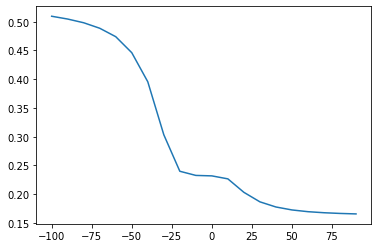

Text(0, 0.5, 'psuedo DCG')

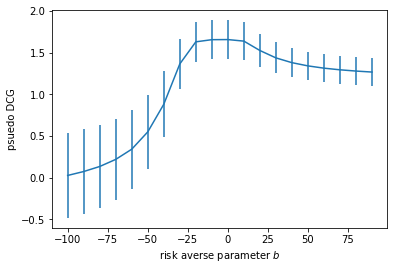

In [182]:
def dcg_multi_query_portfolio(scores_dropout,test_score,data_split,risk_preference_param_n,cutoff=5):
    n_query=data_split.num_queries()
    ranks_scores_list=[]
    for qid in progressbar(range(n_query)):
        score_qid=data_split.query_values_from_vector(qid,scores_dropout) 
        test_score_qid=data_split.query_values_from_vector(qid,test_score) 
        ranks_cur=nn.get_rank_profolio_multiple(score_qid,cutoff,risk_preference_param_n)[0]
        ranks_scores=dcg_single_query_portfolio(ranks_cur,test_score_qid)
        ranks_scores_list.append(ranks_scores)
    ranks_scores_list=np.array(ranks_scores_list)
    print(ranks_scores_list.shape)
    print(ranks_scores_list.mean())
    q_mean=ranks_scores_list.mean(axis=2)
    q_std=ranks_scores_list.std(axis=2)
    mean=q_mean.mean(axis=0)
    std=q_std.mean(axis=0)
    return mean,std


In [181]:
def dcg_single_query_portfolio(ranks_cur,score_qid):
    cutoff=ranks_cur.shape[1]
    scores_rank=score_qid[ranks_cur,:]
    weight=1/np.log2(np.arange(2,cutoff+2))
    weight=weight[None,:,None]
    scores_rank=scores_rank*weight
    reduce_scores=np.sum(scores_rank,axis=1)
    # reduce_mean=reduce_scores.mean(axis=1)
    # reduce_std=reduce_scores.std(axis=1)
    return reduce_scores

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


<ErrorbarContainer object of 3 artists>

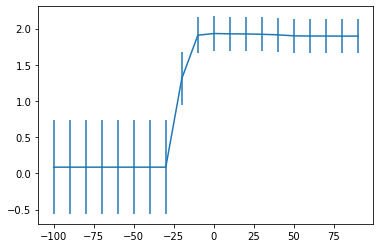

In [151]:
qid=200
data_split=data.test
cutoff=10
risk_preference_param_n=np.arange(-1000,1000,100)/10
qid_feature=data.test.query_values_from_vector(qid,data.test.feature_matrix)

score_qid=nn.get_score_matrix_by_dropout(qid_feature,model_dropout,100)

ranks_cur=nn.get_rank_profolio_multiple(score_qid,cutoff,risk_preference_param_n)[0]
reduce_scores=dcg_single_query_portfolio(ranks_cur,score_qid)
reduce_mean=reduce_scores.mean(axis=1)
reduce_std=reduce_scores.std(axis=1)
import matplotlib.pyplot as plt
plt.errorbar(risk_preference_param_n,reduce_mean,reduce_std)

In [74]:
score_qid_expand=score_qid[None,:,:]

In [87]:

rows=np.ones((5,2)).astype(np.int)
score_qid[ranks_cur,:].shape

(20, 10, 10)

(155, 10)

In [12]:
qid=11
q_feature=data.test.query_values_from_vector(qid,data.test.feature_matrix)
model(q_feature)

<tf.Tensor: id=825, shape=(58, 1), dtype=float64, numpy=
array([[-0.03896015],
       [-0.03866553],
       [-0.02996821],
       [-0.06187   ],
       [ 0.03018535],
       [ 0.03018535],
       [ 0.02903518],
       [ 0.03309566],
       [ 0.03681683],
       [ 0.10084533],
       [ 0.02945438],
       [ 0.06229437],
       [ 0.01212918],
       [ 0.02447237],
       [ 0.0182937 ],
       [ 0.03932713],
       [ 0.03753968],
       [ 0.02572923],
       [ 0.15825724],
       [ 0.05792584],
       [ 0.02210358],
       [ 0.05224188],
       [ 0.22615198],
       [ 0.02373323],
       [ 0.04150915],
       [ 0.01608965],
       [ 0.04546389],
       [ 0.01283657],
       [ 0.09150845],
       [ 0.09988565],
       [ 0.12106285],
       [-0.01233888],
       [ 0.07134896],
       [ 0.31577222],
       [ 0.53049237],
       [ 0.46845167],
       [ 0.03555069],
       [ 0.05140954],
       [ 0.42498637],
       [ 0.03324336],
       [ 0.52892074],
       [ 0.1203384 ],
       [ 0.30336393

In [44]:
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/supervised/trial0/model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output_point_wise/Webscope_C14_Set1/pretrained/trial0/model.h5"
get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":True}
model_dropout=nn.get_dropout_model(**get_model_params)

scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,10)
scores_dropout_T=scores_dropout.T

corre_stat=nn.get_corre_stat(data_split,scores_dropout_T)
print(corre_stat,"my dropout")



get_model_params={"model_params":model_params,
                "input_shape":data.train.feature_matrix.shape,
                "weight_path":dropout_model_weight,
                "dropout_fixed":False}
model_dropout_seed=nn.get_dropout_model(**get_model_params)
scores_dropout_seed=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout_seed,10)
scores_dropout_seed_T=scores_dropout_seed.T
corre_stat_seed=nn.get_corre_stat(data_split,scores_dropout_seed_T)
print(corre_stat_seed,"my dropout")


100% (10 of 10) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

[0.57009778 0.56569571] my dropout


100% (10 of 10) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


[0.11377834 0.11343169] my dropout


In [113]:
from sklearn.metrics import ndcg_score
# risk_preference_params=[-100,-10,-5,-1,-0.5,-0.1,0,0.1,0.5,1,5,10,100]
risk_preference_params=np.arange(-10,10,1)/10
# risk_preference_params=[1]
# scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,100)
# data_split=data.test
# scores_dropout_T=scores_dropout.T
# risk_preference_params=[0]
metrics_dict={}
for risk_preference_param in progressbar(risk_preference_params):
    n_doc_total=scores_dropout_T.shape[0]
    score_profo=np.ones(n_doc_total)
    qids=data_split.num_queries()
    cutoff=5
    ndcg=[]
    cutoff_list=[1,3,5]
    for qid in progressbar(range(qids)):
        risk_preference_param_n=np.array([risk_preference_param]*100)
        ranks_cur=nn.get_rank_profolio_multiple(qid,scores_dropout_T,data_split,cutoff,risk_preference_param_n)
        score_qid=data_split.query_values_from_vector(qid,scores_dropout_T) 
        score_profo_qid=data_split.query_values_from_vector(qid,score_profo)
        rank_len=len(ranks_cur)
        score_profo_qid[ranks_cur]=np.arange(rank_len+1,1,-1)
        weight_profo_qid=data_split.query_values_from_vector(qid,true_test_doc_weights)
        if weight_profo_qid.shape[0]==1:
            continue
        for eval_cutoff in cutoff_list:
            ndcg_score_cur=ndcg_score(weight_profo_qid[None,:],score_profo_qid[None,:],k=eval_cutoff)
            ndcg.append(ndcg_score_cur)
    ndcg=np.array(ndcg)
    ndcg=ndcg.reshape((-1,len(cutoff_list)))
    ndcg_mean=np.mean(ndcg,axis=0)
        # print(np.argsort(-score_profo_qid)[:5])
    metrics_dict[risk_preference_param]=ndcg_mean

N/A% (0 of 6734) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

ValueError: shape mismatch: value array of shape (100,) could not be broadcast to indexing result of shape (100,5)

In [114]:
risk_preference_param_n

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [117]:
from sklearn.metrics import ndcg_score
# risk_preference_params=[-100,-10,-5,-1,-0.5,-0.1,0,0.1,0.5,1,5,10,100]
risk_preference_params=np.arange(-10,10,1)/10
risk_preference_params=[1]
# scores_dropout=nn.get_score_matrix_by_dropout(data.test.feature_matrix,model_dropout,100)
# data_split=data.test
# scores_dropout_T=scores_dropout.T
# risk_preference_params=[0]
metrics_dict={}
for risk_preference_param in progressbar(risk_preference_params):
    n_doc_total=scores_dropout_T.shape[0]
    score_profo=np.ones(n_doc_total)
    qids=data_split.num_queries()
    cutoff=5
    ndcg=[]
    cutoff_list=[1,3,5]
    for qid in progressbar(range(qids)):
        risk_preference_param1=np.array([risk_preference_param]*100)
        ranks_cur=nn.get_rank_profolio_multiple(qid,scores_dropout_T,data_split,cutoff,risk_preference_param1)
        # print(ranks_cur.shape)

100% (6734 of 6734) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (1 of 1) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


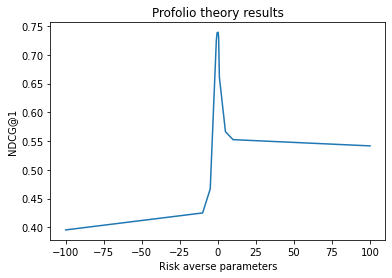

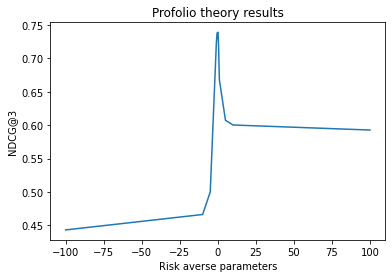

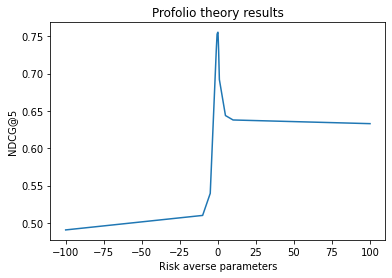

In [16]:
import matplotlib.pyplot as plt 
for ind,cutoff in enumerate(cutoff_list):
    ndcg_profolio=[metrics_dict[key][ind] for key in  metrics_dict.keys()]
    plt.plot(metrics_dict.keys(),ndcg_profolio)
    plt.xlabel("Risk averse parameters")
    plt.ylabel("NDCG@"+str(cutoff))
    plt.title("Profolio theory results")
    plt.show()

In [17]:
metrics_dict

{-100: array([0.39538664, 0.4431183 , 0.4906381 ]),
 -10: array([0.42494292, 0.46620938, 0.51004951]),
 -5: array([0.46679571, 0.49989038, 0.53957722]),
 -1: array([0.72519605, 0.72245029, 0.73297094]),
 -0.5: array([0.73855966, 0.73818625, 0.75275263]),
 -0.1: array([0.73882023, 0.73863193, 0.75504349]),
 0: array([0.73949027, 0.73888495, 0.75528987]),
 0.1: array([0.73950268, 0.73916191, 0.75536992]),
 0.5: array([0.7322439 , 0.71685179, 0.73206579]),
 1: array([0.66159172, 0.6681856 , 0.69204326]),
 5: array([0.56628449, 0.60730425, 0.64380473]),
 10: array([0.55253623, 0.60025398, 0.63787614]),
 100: array([0.54167907, 0.59270583, 0.6329521 ])}

In [ ]:
## I will fixed one qid
risk_preference_params=[-100,-10,-5,-1,-0.5,-0.1,0,0.1,0.5,1,5,10,100]
# risk_preference_params=[0]
metrics_dict={}
for risk_preference_param in progressbar(risk_preference_params):
    n_doc_total=scores_dropout_T.shape[0]
    score_profo=np.ones(n_doc_total)
    qids=data_split.num_queries()
    cutoff=5
    qid=5
    ranks_cur=get_rank_profolio(qid,scores_dropout_T,cutoff,risk_preference_param)
    score_qid=data_split.query_values_from_vector(qid,scores_dropout_T)
    score_qid_mean=np.mean(score_qid,axis=1)
    # print(np.argsort(-score_qid_mean)[:5])
    # print(ranks_cur)
    # print(np.all(np.argsort(-score_qid_mean)[:5]==ranks_cur))
    score_profo_qid=data_split.query_values_from_vector(qid,score_profo)
    rank_len=len(ranks_cur)
    score_profo_qid[ranks_cur]=np.arange(rank_len+1,1,-1)
    # print(np.argsort(-score_profo_qid)[:5])
    

    metrics_dict[risk_preference_param]=metrics

In [664]:
# j=np.random.uniform((10**7,500))

In [595]:

from utils.nnmodel import init_model_dropout
model_params={}
model_params['hidden units']=[32,32]
model_dropout=init_model_dropout(model_params)
model_dropout.build(input_shape=data.train.feature_matrix.shape)
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/settings/supervised/Supervised_dropout_model.h5"
dropout_model_weight="/home/ec2-user/documents/uncertainty/2021wsdm-unifying-LTR/local_output/pretrained_model.h5"

model_dropout.load_weights(dropout_model_weight)
# model_dropout.compile(optimizer='adam',
#               loss=loss_sigmoid, # Call the loss function with the selected layer
#               metrics=[loss_sigmoid])



In [1]:
import logging
import sys
import matplotlib.pyplot as plt
sys.path.append("/home/ec2-user/my_repo")
from BEL.utils import configure_logging
configure_logging(logging)

ModuleNotFoundError: No module named 'BEL'

In [115]:
item_freq

array([38., 40., 43., 45., 48., 51., 55., 59., 63., 68.])

In [2]:
from utils.plackettluce  import ucb_rankings,std_proposional_rankings,ucb_std_rankings


In [3]:
import numpy as np
import utils.nnmodel as nn
scores=np.random.uniform(0,1,(20,100))
risk_param=np.arange(0,1)/10
cutoff=5
param_c=100
rankings=nn.get_rank_profolio_multiple(scores,cutoff,risk_param)[0]

In [13]:
scores=np.random.uniform(0,1,(20,10))
risk_param=0
std_proposional_rankings(scores,10,5,param_c=0)

(array([[13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16]]), None, None, None)

In [5]:
%load_ext autoreload
%autoreload 2


In [14]:
# scores=np.random.uniform(0,1,(20,10))
risk_param=0
doc_freq=np.array([1]*20)
query_freq=np.array([1])
ucb_std_rankings(scores,10,5,doc_freq,query_freq,param_c=0)

(array([[13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16],
        [13,  5,  7,  2, 16]]), None, None, None)

In [17]:
import utils.misc as mis

In [27]:
vali=data.validation
n_doc=vali.num_docs()
score=np.random.randint(-1,3,(n_doc))

In [28]:
mis.test_ips(vali,score=score)

[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[2 2 2 2 2]
[1 2 2 2 2]
[]


In [26]:
score

array([-1,  2,  0, ...,  1, -1,  2])

In [60]:
query_rng=np.random.default_rng(1)

In [ ]:
policy_scores_masked=np.zeros_like(policy_scores_query)
policy_scores_masked[:]=policy_scores_query
policy_scores_masked[mask_query==0]=-np.inf*flag

In [68]:
def mask_items(mask_query,policy_scores_query,flag=1):
    policy_scores_masked=np.zeros_like(policy_scores_query)
    policy_scores_masked[:]=policy_scores_query
    policy_scores_masked[mask_query==0]=-np.inf*flag
    return policy_scores_masked


In [69]:
mask_query=np.random.randint(0,2,10)
policy_scores_query=np.random.uniform(0,1,10)

In [70]:
mask_items(mask_query,policy_scores_query)

array([0.78665592,       -inf,       -inf,       -inf, 0.72989563,
       0.58672937,       -inf, 0.8851502 ,       -inf, 0.27788456])

In [80]:
d=np.zeros((10,10))

In [81]:
dd=d[:,9]

In [82]:
dd[:]=np.ones(10)

In [83]:
d

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [78]:
train_ranking_mask=np.random.randint(0,2,100)

In [79]:
np.sum(train_ranking_mask==1)

50

In [9]:
9.8*1.2

11.76

In [84]:
from utils.clicks import get_click_model

In [85]:
a=get_click_model("default")

In [88]:
a(np.arange(5))

(array([0.35      , 0.53203166, 0.54726198, 0.53700475, 0.52015654]),
 array([0.65      , 0.25806548, 0.15330808, 0.10606658, 0.07951667]))

In [ ]:
def L2(exposure,rel):
    exposure=exposure/exposure.sum()
    rel=rel/rel.sum()
    return np.abs(exposure-rel)

def test_unfairness(exposure,data_split,true_doc_weights,mask):
#     feature_matrix=data_split.feature_matrix
    # scores=model(feature_matrix)[:,0].numpy()
    filtered_queries=data_split.get_filtered_queries()
    unfairness_list=[]
    for qid in filtered_queries:
        q_mask=data_split.query_values_from_vector(qid,mask)
        q_exposure=data_split.query_values_from_vector(qid,exposure)
        q_rel=data_split.query_values_from_vector(qid,true_doc_weights)
        unfairness_list.append(L2(q_exposure,q_rel))
    unfairness_list=np.array(unfairness_list)
    return np.mean(unfairness_list)

In [2]:
import numpy as np

In [7]:
d=np.random.randint(0,2,(10))
m=np.random.randint(0,2,(10))
mm=np.setdiff1d(m,d)
print(m,d,mm)

[1 0 0 1 0 0 1 1 1 0] [1 0 0 0 1 1 0 0 0 0] []


In [23]:
label=np.random.randint(3,5,(100))
clicks=np.random.randint(0,10,(100))
shown_test_id=[np.arange(i*10,(i+1)*10) for i in range(5)]

In [29]:
result=time_stamp_clicks(clicks,label,shown_test_id)
print(result)

[3 5 2 7 5] [0 1 2 3 4 5 6 7 8 9] [3 4 3 4 3 4 4 3 4 3 3 3 3 3 4 4 3 4 4 4 3 3 4 3 3 3 4 3 4 3 4 3 3 4 3 4 4
 3 4 4 3 4 4 4 3 4 4 3 3 4 4 4 3 3 3 3 3 3 4 4 4 3 4 4 3 3 3 4 4 4 3 4 3 3
 4 3 4 3 3 4 3 4 4 3 3 4 3 3 3 4 3 3 3 4 3 4 4 3 4 4] [8 3 8 5 6 2 7 3 5 3 7 5 1 5 0 5 4 0 7 2 8 5 7 4 4 6 9 0 7 1 1 6 5 9 1 7 9
 4 0 6 2 1 4 9 0 6 0 3 9 2 4 5 8 4 6 9 3 3 6 3 0 1 0 2 3 0 7 3 9 5 3 9 5 0
 7 1 3 5 1 0 2 8 2 5 2 2 9 8 6 2 3 1 0 4 7 4 8 7 3 4]
[0 5 0 7 2] [10 11 12 13 14 15 16 17 18 19] [3 4 3 4 3 4 4 3 4 3 3 3 3 3 4 4 3 4 4 4 3 3 4 3 3 3 4 3 4 3 4 3 3 4 3 4 4
 3 4 4 3 4 4 4 3 4 4 3 3 4 4 4 3 3 3 3 3 3 4 4 4 3 4 4 3 3 3 4 4 4 3 4 3 3
 4 3 4 3 3 4 3 4 4 3 3 4 3 3 3 4 3 3 3 4 3 4 4 3 4 4] [8 3 8 5 6 2 7 3 5 3 7 5 1 5 0 5 4 0 7 2 8 5 7 4 4 6 9 0 7 1 1 6 5 9 1 7 9
 4 0 6 2 1 4 9 0 6 0 3 9 2 4 5 8 4 6 9 3 3 6 3 0 1 0 2 3 0 7 3 9 5 3 9 5 0
 7 1 3 5 1 0 2 8 2 5 2 2 9 8 6 2 3 1 0 4 7 4 8 7 3 4]
[7 9 7] [20 21 22 23 24 25 26 27 28 29] [3 4 3 4 3 4 4 3 4 3 3 3 3 3 4 4 3 4 4 4 3 3 4 3 3 3 4 3 4 3 4 3 3